In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

# GPU 사용 여부 확인 및 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Stick Figure KNeighborsRegression Model 구현

def load_images(image_path, y_train=None):
    images = []
    for filename in os.listdir(image_path):
        if y_train is not None:
            if (filename in y_train) is False:
                continue
        img = cv2.imread(os.path.join(image_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (32, 32))  # 이미지 크기 조정
            img = img.flatten()  # 이미지 일차원 배열로 변환
            images.append(img)
    return np.array(images)


# CSV(목푯값) 불러오는 함수 -> 첫 번째 열(이미지 이름) 제외
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    joint = df.iloc[:, 1:].to_numpy()
    return joint


# 데이터셋 경로 지정
X_train = load_images("./image_train_f/")
y_train = load_csv("./joint_train_f.csv")

X_test = load_images("./image_test/")
y_test = load_csv("./joint_test.csv")

X_ex = load_images("./image_ex/")
y_ex = load_csv("./joint_ex.csv")


# 데이터를 Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_ex = torch.tensor(X_ex, dtype=torch.float32)
y_ex = torch.tensor(y_ex, dtype=torch.float32)


# 모델 정의
class KNNRegressor(nn.Module):
    def __init__(self, k):
        super(KNNRegressor, self).__init__()
        self.k = k

    def forward(self, x):
        # 테스트 데이터와의 거리 계산
        dist = torch.cdist(x, self.X_train)
        _, indices = torch.topk(dist, self.k, largest=False)

        # K개의 최근접 이웃의 평균값 계산
        y_pred = torch.mean(self.y_train[indices], dim=1)
        return y_pred

    def set_train_data(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train


# 모델 인스턴스 생성
k = 9
model = KNNRegressor(k)
model.to(device)

# 모델 정의 및 데이터 이동이 위에서 수행되었으므로, K값 변경을 위한 for문만 추가해줍니다.

k_values = range(1, 15)  # 1부터 10까지의 K 값을 시험해보기로 합니다. 이 범위는 필요에 따라 조정하실 수 있습니다.
results = []

for k in k_values:
    model = KNNRegressor(k)
    model.to(device)
    model.set_train_data(X_train, y_train)
    
    # 모델 학습 및 예측
    model.eval()
    y_pred = model(X_test)
    y_pred_ex = model(X_ex)
    
    # 결과를 CPU로 이동
    y_test_cpu = y_test.cpu().detach().numpy()
    y_pred_cpu = y_pred.cpu().detach().numpy()
    
    # 모델 평가
    r2 = r2_score(y_test_cpu, y_pred_cpu)
    
    # 오차 평균 구하기
    average = np.mean(y_test_cpu - y_pred_cpu)
    
    results.append((k, r2, abs(average)))
    print(f'For k={k}: R2 score: {r2:.4f}, MAE: {abs(average):.4f}')

# 모든 K값에 대한 결과를 데이터프레임으로 저장
results_df = pd.DataFrame(results, columns=["K", "R2 Score", "MAE"])


# 데이터를 GPU로 이동
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_ex = X_ex.to(device)
y_ex = y_ex.to(device)

# 모델에 훈련 데이터 설정
model.set_train_data(X_train, y_train)

# 모델 학습 및 예측
model.eval()
y_pred = model(X_test)
y_pred_ex = model(X_ex)

# 결과를 CPU로 이동
y_test = y_test.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
y_ex = y_ex.cpu().detach().numpy()
y_pred_ex = y_pred_ex.cpu().detach().numpy()

# 모델 평가
r2 = r2_score(y_test, y_pred)


# 오차 평균 구하기
average = np.mean(y_test - y_pred)


print('Test set: R2 score: {:.4f}, MAE: {:.4f}'.format(r2, abs(average)))

print(results_df)

import matplotlib.pyplot as plt

# 결과를 데이터프레임에서 분리
k_values = results_df['K']
r2_scores = results_df['R2 Score']
mae_values = results_df['MAE']

# 결과 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, r2_scores, marker='o')
plt.title('R2 Score vs K')
plt.xlabel('K')
plt.ylabel('R2 Score')

plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, marker='o')
plt.title('MAE vs K')
plt.xlabel('K')
plt.ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()

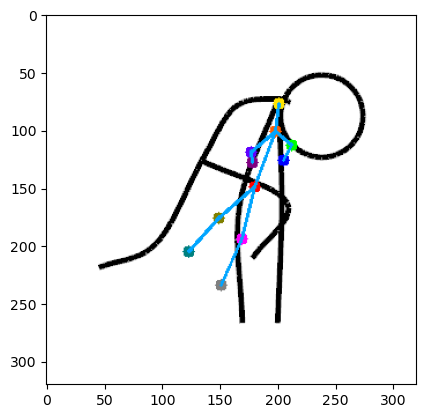

In [6]:
imageFile = './image_ex/sf000612.png'
X_ex_image = cv2.imread(imageFile)

#print(X_ex_image)
#이미지, 점 출력
#plt.imshow(X_ex_image)
#plt.show()

#predictions
#y_ex

# 각 관절 위치 값 저장
data=y_pred_ex[0]

c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(X_ex_image,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(X_ex_image,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(X_ex_image,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(X_ex_image,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(X_ex_image,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(X_ex_image,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(X_ex_image,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(X_ex_image,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(X_ex_image,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(X_ex_image,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(X_ex_image,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


# 각 연결을 나타내는 튜플 리스트
connections = [(c1_x, c1_y, c2_x, c2_y),
               (c2_x, c2_y, c3_x, c3_y),
               (c2_x, c2_y, le_x, le_y),
               (c2_x, c2_y, re_x, re_y),
               (le_x, le_y, lh_x, lh_y),
               (re_x, re_y, rh_x, rh_y),
               (c1_x, c1_y, lk_x, lk_y),
               (c1_x, c1_y, rk_x, rk_y),
               (lk_x, lk_y, lf_x, lf_y),
               (rk_x, rk_y, rf_x, rf_y)]

# 주황색 RGB 값
orange = (255, 165, 0)

# 각 연결에 대해 선을 그립니다
for conn in connections:
    cv2.line(X_ex_image, (conn[0], conn[1]), (conn[2], conn[3]), orange, thickness=2)

# 색상 공간을 RGB로 변환하고 이미지를 출력합니다
img = cv2.cvtColor(X_ex_image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


